In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [14]:
model_builder = keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

In [15]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = ["block5_pool", "flatten", "fc1", "fc2", "predictions"]

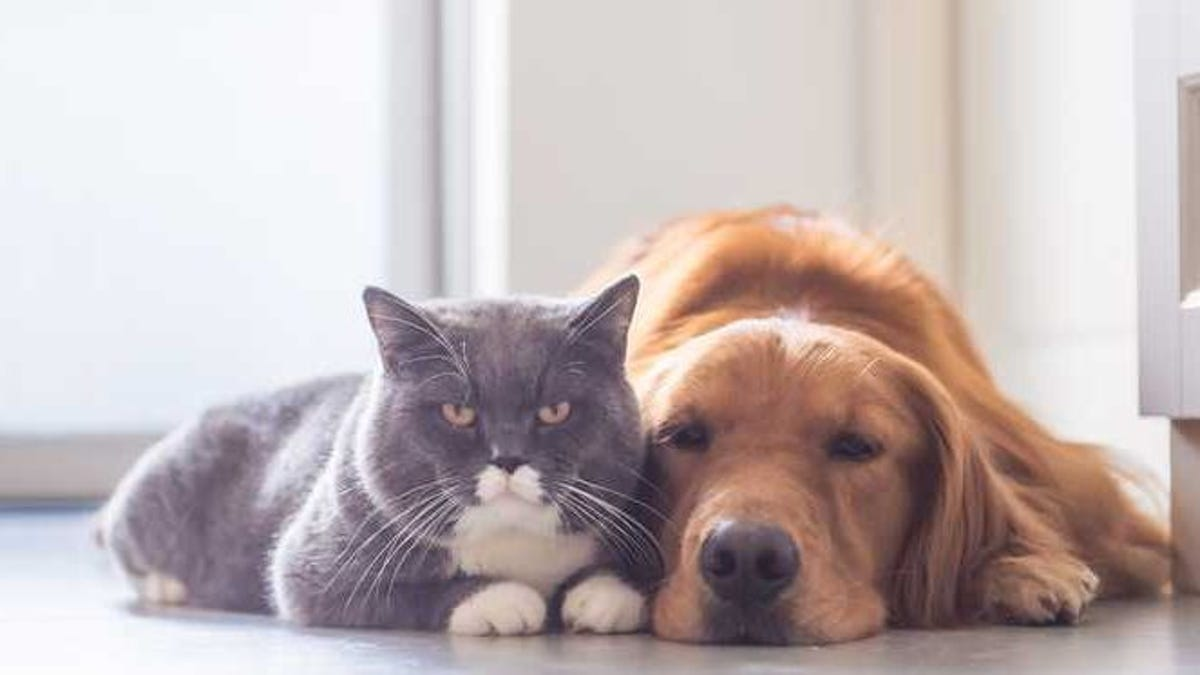

In [16]:
img_path="catdog.jpg"
display(Image(img_path))

In [17]:
def get_img_array(img_path, size):
    
  # `img` is a PIL image of size 299x299
  img = keras.preprocessing.image.load_img(img_path, target_size=size)
  # `array` is a float32 Numpy array of shape (299, 299, 3)
  array = keras.preprocessing.image.img_to_array(img)
  # We add a dimension to transform our array into a "batch"
  # of size (1, 299, 299, 3)
  array = np.expand_dims(array, axis=0)
  return array

In [18]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
  
  #Imprime o modelo da rede ate a ultima camada convolucional
  print("\nlast_conv_layer_model:"); last_conv_layer_model.summary(); print()

  # Second, we create a model that maps the activations of the last conv
  # layer to the final class predictions
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

  #Imprime o modelo da rede da ultima camada convolucional ate predicao
  print("\nclassifier_model:"); classifier_model.summary(); print()

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    print("preds:",type(preds),preds.shape,preds.dtype)
    top_pred_index = tf.argmax(preds[0])
    print("top_pred_index:",top_pred_index)
    top_class_channel = preds[:, top_pred_index]
    print("top_class_channel:",top_class_channel,
          type(top_class_channel),top_class_channel.shape,top_class_channel.dtype)

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  print("grads:",type(grads),grads.shape,grads.dtype)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  print("pooled_grads:",type(pooled_grads),pooled_grads.shape,pooled_grads.dtype)

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  print("last_conv_layer_output:",type(last_conv_layer_output),
        last_conv_layer_output.shape,last_conv_layer_output.dtype)
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  print("last_conv_layer_output:",type(last_conv_layer_output),
        last_conv_layer_output.shape,last_conv_layer_output.dtype)
  pooled_grads = pooled_grads.numpy()
  print("pooled_grads:",type(pooled_grads),pooled_grads.shape,pooled_grads.dtype)  
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  print("last_conv_layer_output:",type(last_conv_layer_output),
        last_conv_layer_output.shape,last_conv_layer_output.dtype)

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  # Elimina parte negativa (relu)
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
# Prepare image
  return heatmap

In [19]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [21]:
# Make model
model = model_builder(weights="imagenet"); #model.summary()

553467904/553467096 [==============================] - 65s 0us/step


In [22]:
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02090379', 'redbone', 0.44541678)]


In [23]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)


last_conv_layer_model:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (

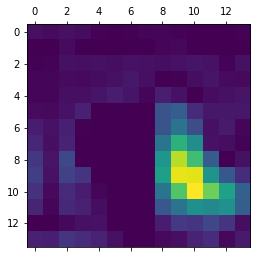

In [24]:
# Display heatmap
plt.matshow(heatmap); plt.show()

In [25]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

In [26]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

In [27]:
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

In [28]:
# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

In [29]:
# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [30]:
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

In [31]:
# Save the superimposed image
save_path = "cam_"+img_path; superimposed_img.save(save_path)

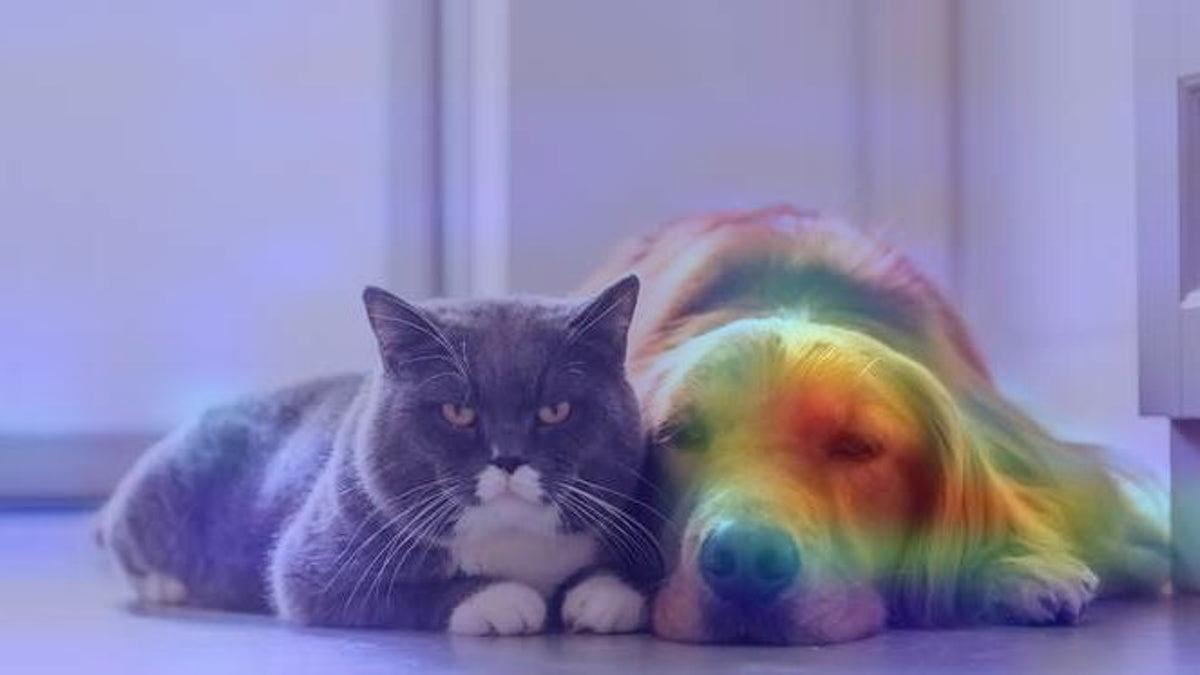

In [32]:
# Display Grad CAM
display(Image(save_path))

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
  
  #Imprime o modelo da rede ate a ultima camada convolucional
  print("\nlast_conv_layer_model:"); last_conv_layer_model.summary(); print()

  # Second, we create a model that maps the activations of the last conv
  # layer to the final class predictions
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

  #Imprime o modelo da rede da ultima camada convolucional ate predicao
  print("\nclassifier_model:"); classifier_model.summary(); print()

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    print("preds:",type(preds),preds.shape,preds.dtype)
    top_pred_index = tf.argmax(preds[0])
    print("top_pred_index:",top_pred_index)
    top_class_channel = preds[:, 282]
    print("top_class_channel:",top_class_channel,
          type(top_class_channel),top_class_channel.shape,top_class_channel.dtype)

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  print("grads:",type(grads),grads.shape,grads.dtype)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  print("pooled_grads:",type(pooled_grads),pooled_grads.shape,pooled_grads.dtype)

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  print("last_conv_layer_output:",type(last_conv_layer_output),
        last_conv_layer_output.shape,last_conv_layer_output.dtype)
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  print("last_conv_layer_output:",type(last_conv_layer_output),
        last_conv_layer_output.shape,last_conv_layer_output.dtype)
  pooled_grads = pooled_grads.numpy()
  print("pooled_grads:",type(pooled_grads),pooled_grads.shape,pooled_grads.dtype)  
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  print("last_conv_layer_output:",type(last_conv_layer_output),
        last_conv_layer_output.shape,last_conv_layer_output.dtype)

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  # Elimina parte negativa (relu)
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
# Prepare image
  return heatmap

In [35]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [36]:
# Make model
model = model_builder(weights="imagenet"); #model.summary()

In [37]:
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

Predicted: [('n02090379', 'redbone', 0.44541678)]


In [38]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)


last_conv_layer_model:
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (

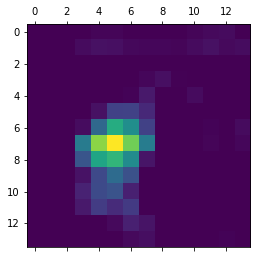

In [39]:
# Display heatmap
plt.matshow(heatmap); plt.show()

In [40]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

In [41]:
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

In [42]:
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

In [43]:
# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

In [44]:
# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [45]:
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

In [46]:
# Save the superimposed image
save_path = "cam_"+img_path; superimposed_img.save(save_path)

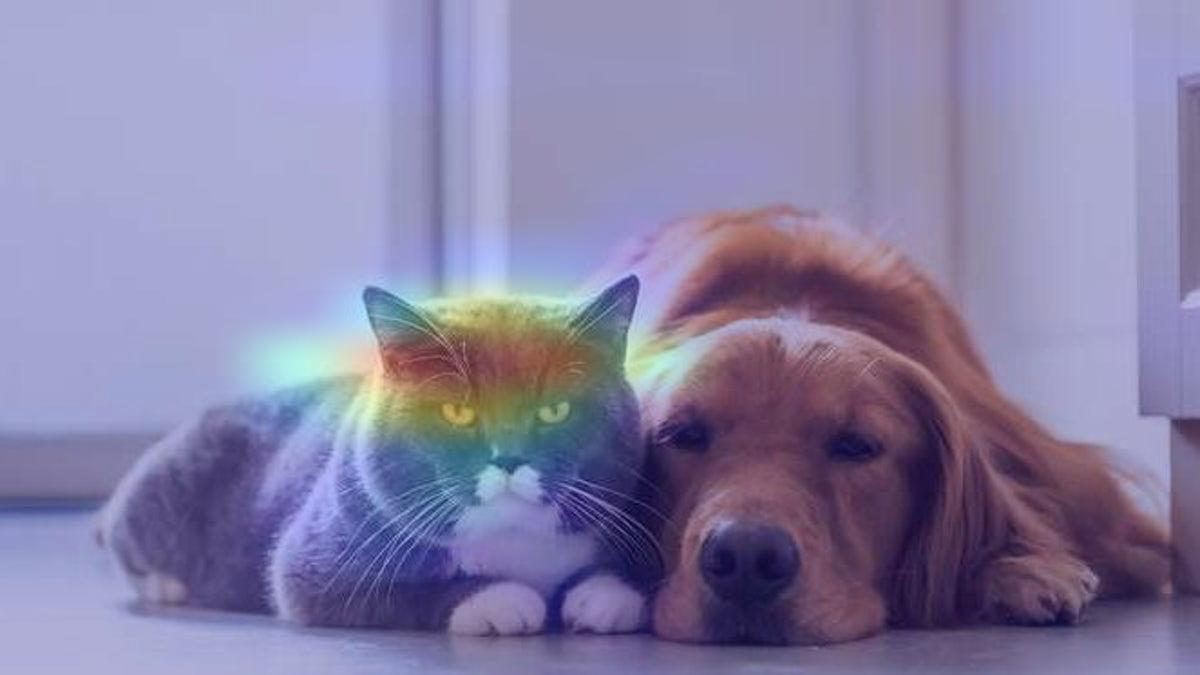

In [47]:
# Display Grad CAM
display(Image(save_path))